In [5]:
from huggingface_hub import whoami

try:
    user_info = whoami()
    print(f"로그인 상태입니다. 사용자: {user_info['name']}")
except Exception as e:
    print("로그인되지 않았거나 토큰이 유효하지 않습니다.")
    print(e)

로그인 상태입니다. 사용자: chaeeee


In [1]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv()

True

In [2]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"

In [6]:
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)


In [7]:
import torch
from langchain import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

# 모델과 토크나이저 로드 (CUDA 사용)
model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="cuda",  # CUDA에서 자동 배치
    trust_remote_code=True
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:28<00:00,  7.23s/it]


In [8]:
from transformers import pipeline

# 파이프라인 생성
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,  # 생성할 최대 토큰 수 증가
    do_sample=True,        # 샘플링 활성화
    temperature=0.1,      
    top_k=50,             
    repetition_penalty=1.05
)
# LangChain의 HuggingFacePipeline 사용
llm = HuggingFacePipeline(pipeline=pipe)

Device set to use cuda
/tmp/ipykernel_62288/1315975019.py:15: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)


In [9]:
from langchain.prompts import ChatPromptTemplate

template = '''
<|system|>
You are a friendly chatbot specializing in artworks and general conversations.
Your primary role is to answer questions strictly based on the information provided in the document (context). 
If the requested information is not found in the document, respond with:
"The document does not contain this information." in Korean.

However, if the question is a general conversation or does not relate to the document, you should respond naturally as a conversational chatbot. 
You can talk about art history, artists, exhibitions, and general topics such as daily life, technology, and culture. 
Maintain a friendly and engaging tone, ensuring all responses are written in **Korean**.
Always use **beautiful Markdown formatting** (headings, bullet points, bold or italic text) to enhance readability.

<|context|>
{context}

<|user|>
Question: {question}

<|assistant|>
'''

# 프롬프트 템플릿 생성
prompt = ChatPromptTemplate.from_template(template)

In [10]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2", verbose=1)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


In [11]:
RAG.index(
    input_path="./dataset/artworks_10_6-8.pdf",
    index_name="korean_doc",
    store_collection_with_index=True,
    overwrite=True
)

overwrite is on. Deleting existing index korean_doc to build a new one.
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Index exported to .byaldi/korean_doc
Index exported to .byaldi/korean_doc


{0: 'dataset/artworks_10_6-8.pdf'}

In [12]:
RAG.index

<bound method RAGMultiModalModel.index of <byaldi.RAGModel.RAGMultiModalModel object at 0x7f5746f34c20>>

In [13]:
query = "DeepSeek는 어디에서 만들었어?"
results = RAG.search(query, k=1)
results

[{'doc_id': 0, 'page_num': 1, 'score': 9.625, 'metadata': {}, 'base64': 'iVBORw0KGgoAAAANSUhEUgAACtQAAAexCAIAAAAUjWKsAAEAAElEQVR4nOzddXxTSb/H8UmbukALVGix4m7FncXddXF3d3eKu1uxFnf3XdzdC7QUKKXUqDdy/8huNiRpKim78NzP+3ndvSfnzJG0IUnPfOc3EqVSKQAAAAAAAAAAAAAAANLK5L++AAAAAAAAAAAAAAAA8GsjfAAAAAAAAAAAAAAAAIxC+AAAAAAAAAAAAAAAABiF8AEAAAAAAAAAAAAAADAK4QMAAAAAAAAAAAAAAGAUwgcAAAAAAAAAAAAAAMAohA8AAAAAAAAAAAAAAIBRCB8AAAAAAAAAAAAAAACjED4AAAAAAAAAAAAAAABGIXwAAAAAAAAAAAAAAACMQvgAAAAAAAAAAAAAAAAYhfABAAAAAAAAAAAAAAAwCuEDAAAAAAAAAAAAAABgFMIHAAAAAAAAAAAAAADAKIQPAAAAAAAAAAAAAACAUQgfAAAAAAAAAAAAAAAAoxA+AAAAAAAAAAAAAAAARiF8AAAAAAAAAAAAAAAAjEL4AAAAAAAAAAAAAAAAGIXwAQAAAAAAAAAAAAAAMArhAwAAAAAAAAAAAAAAYBTCBwAAAAAAAAAAAAAAwCiEDwAAAAAAAAAAAAAAgFEIHwAAAAAAAAAAAAAAAKMQPgAAAAAAAAAAAAAAAEYhfAAAAAAAAAAAAAAAAIxC+AAAAAAAAAAAAAAAABiF8AEAAAAAAAAAAAAAADAK4QMAAAAAAAAAAAAAAGAUwgcAAAAAAAAAAAAAAMAohA8AAAAAAAAAAAAAAIBRCB8AAAAAAAAAAAAAAACjED4AAAAAAAAAAAAAAABGIXwAAAAAAAAAAAAAAACMQvgAAAAAAAAAAAAAAAAYhfABAAAAAAAAAAAAAAAwCuEDAAAAAAAAAAAAAAB

In [14]:
import base64
image_bytes = base64.b64decode(results[0].base64)

In [15]:
filename = 'image.jpg'  # I assume you have a JPG file
with open(filename, 'wb') as f:
  f.write(image_bytes)

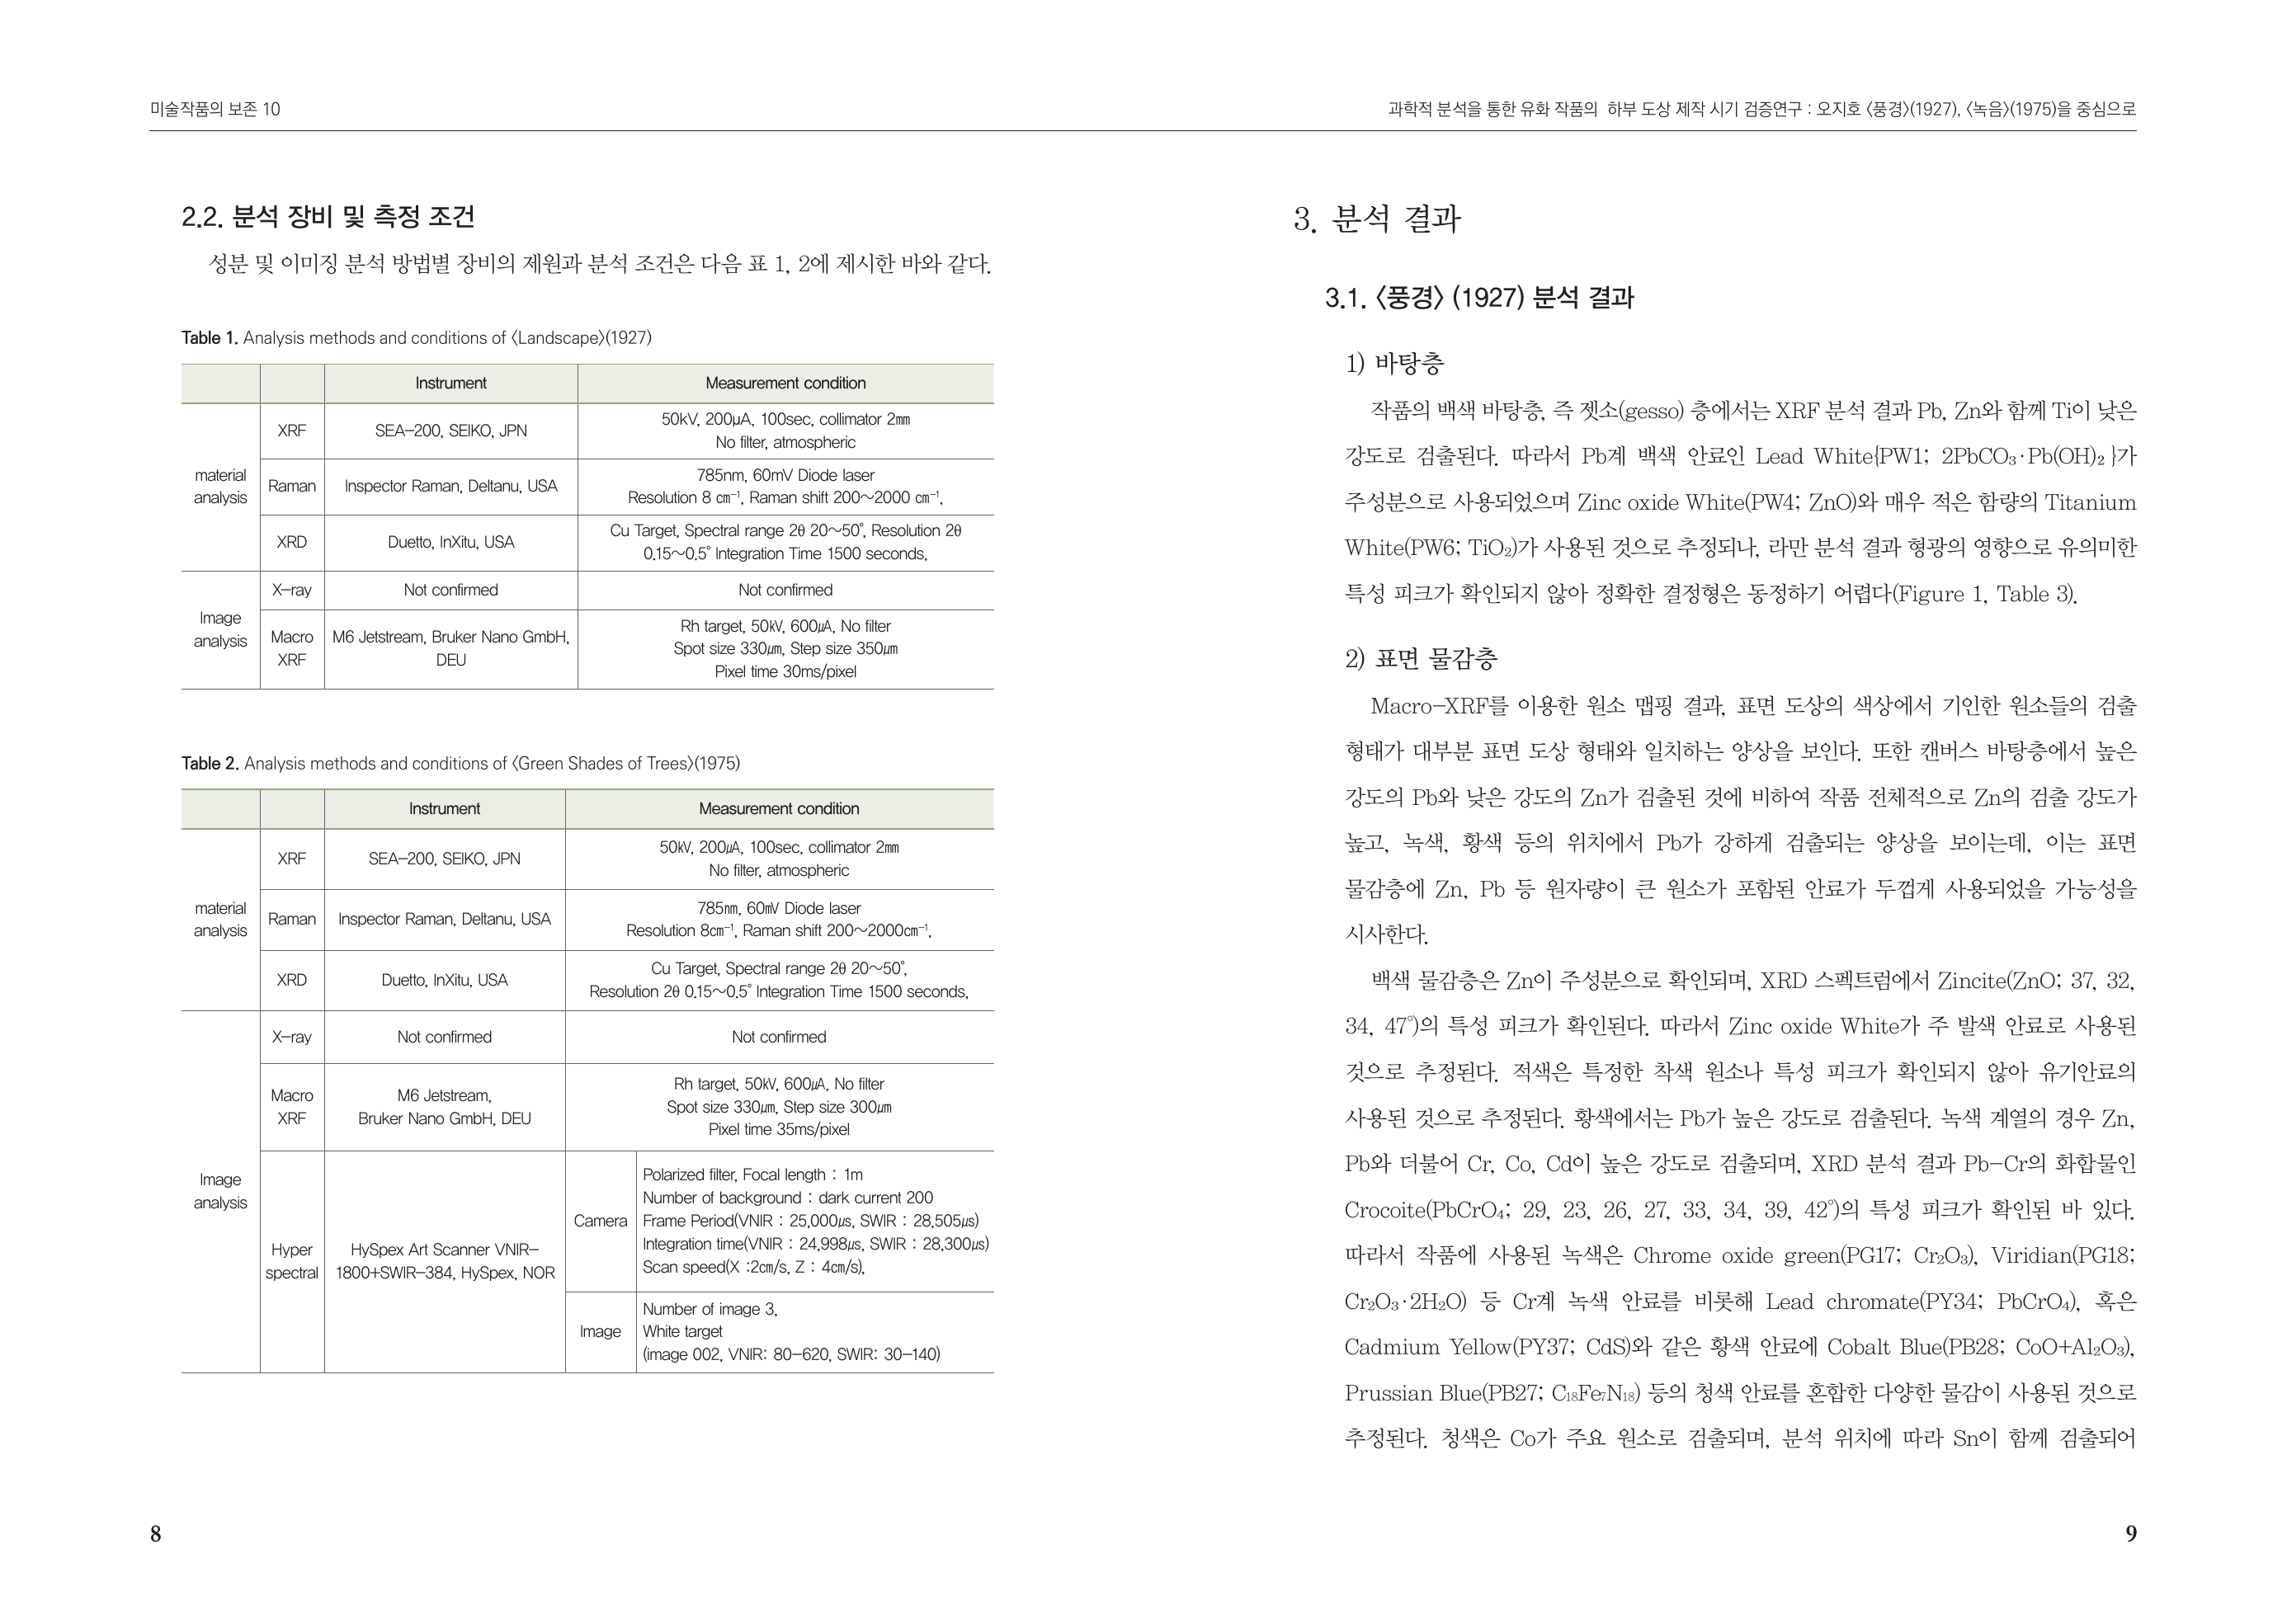

In [16]:
from IPython.display import Image

display(Image(filename))

In [17]:
query = "이미징 분석 방법별 장비의 제원과 분석 조건은 어떠한가요?"
results = RAG.search(query, k=1)
image_bytes = base64.b64decode(results[0].base64)

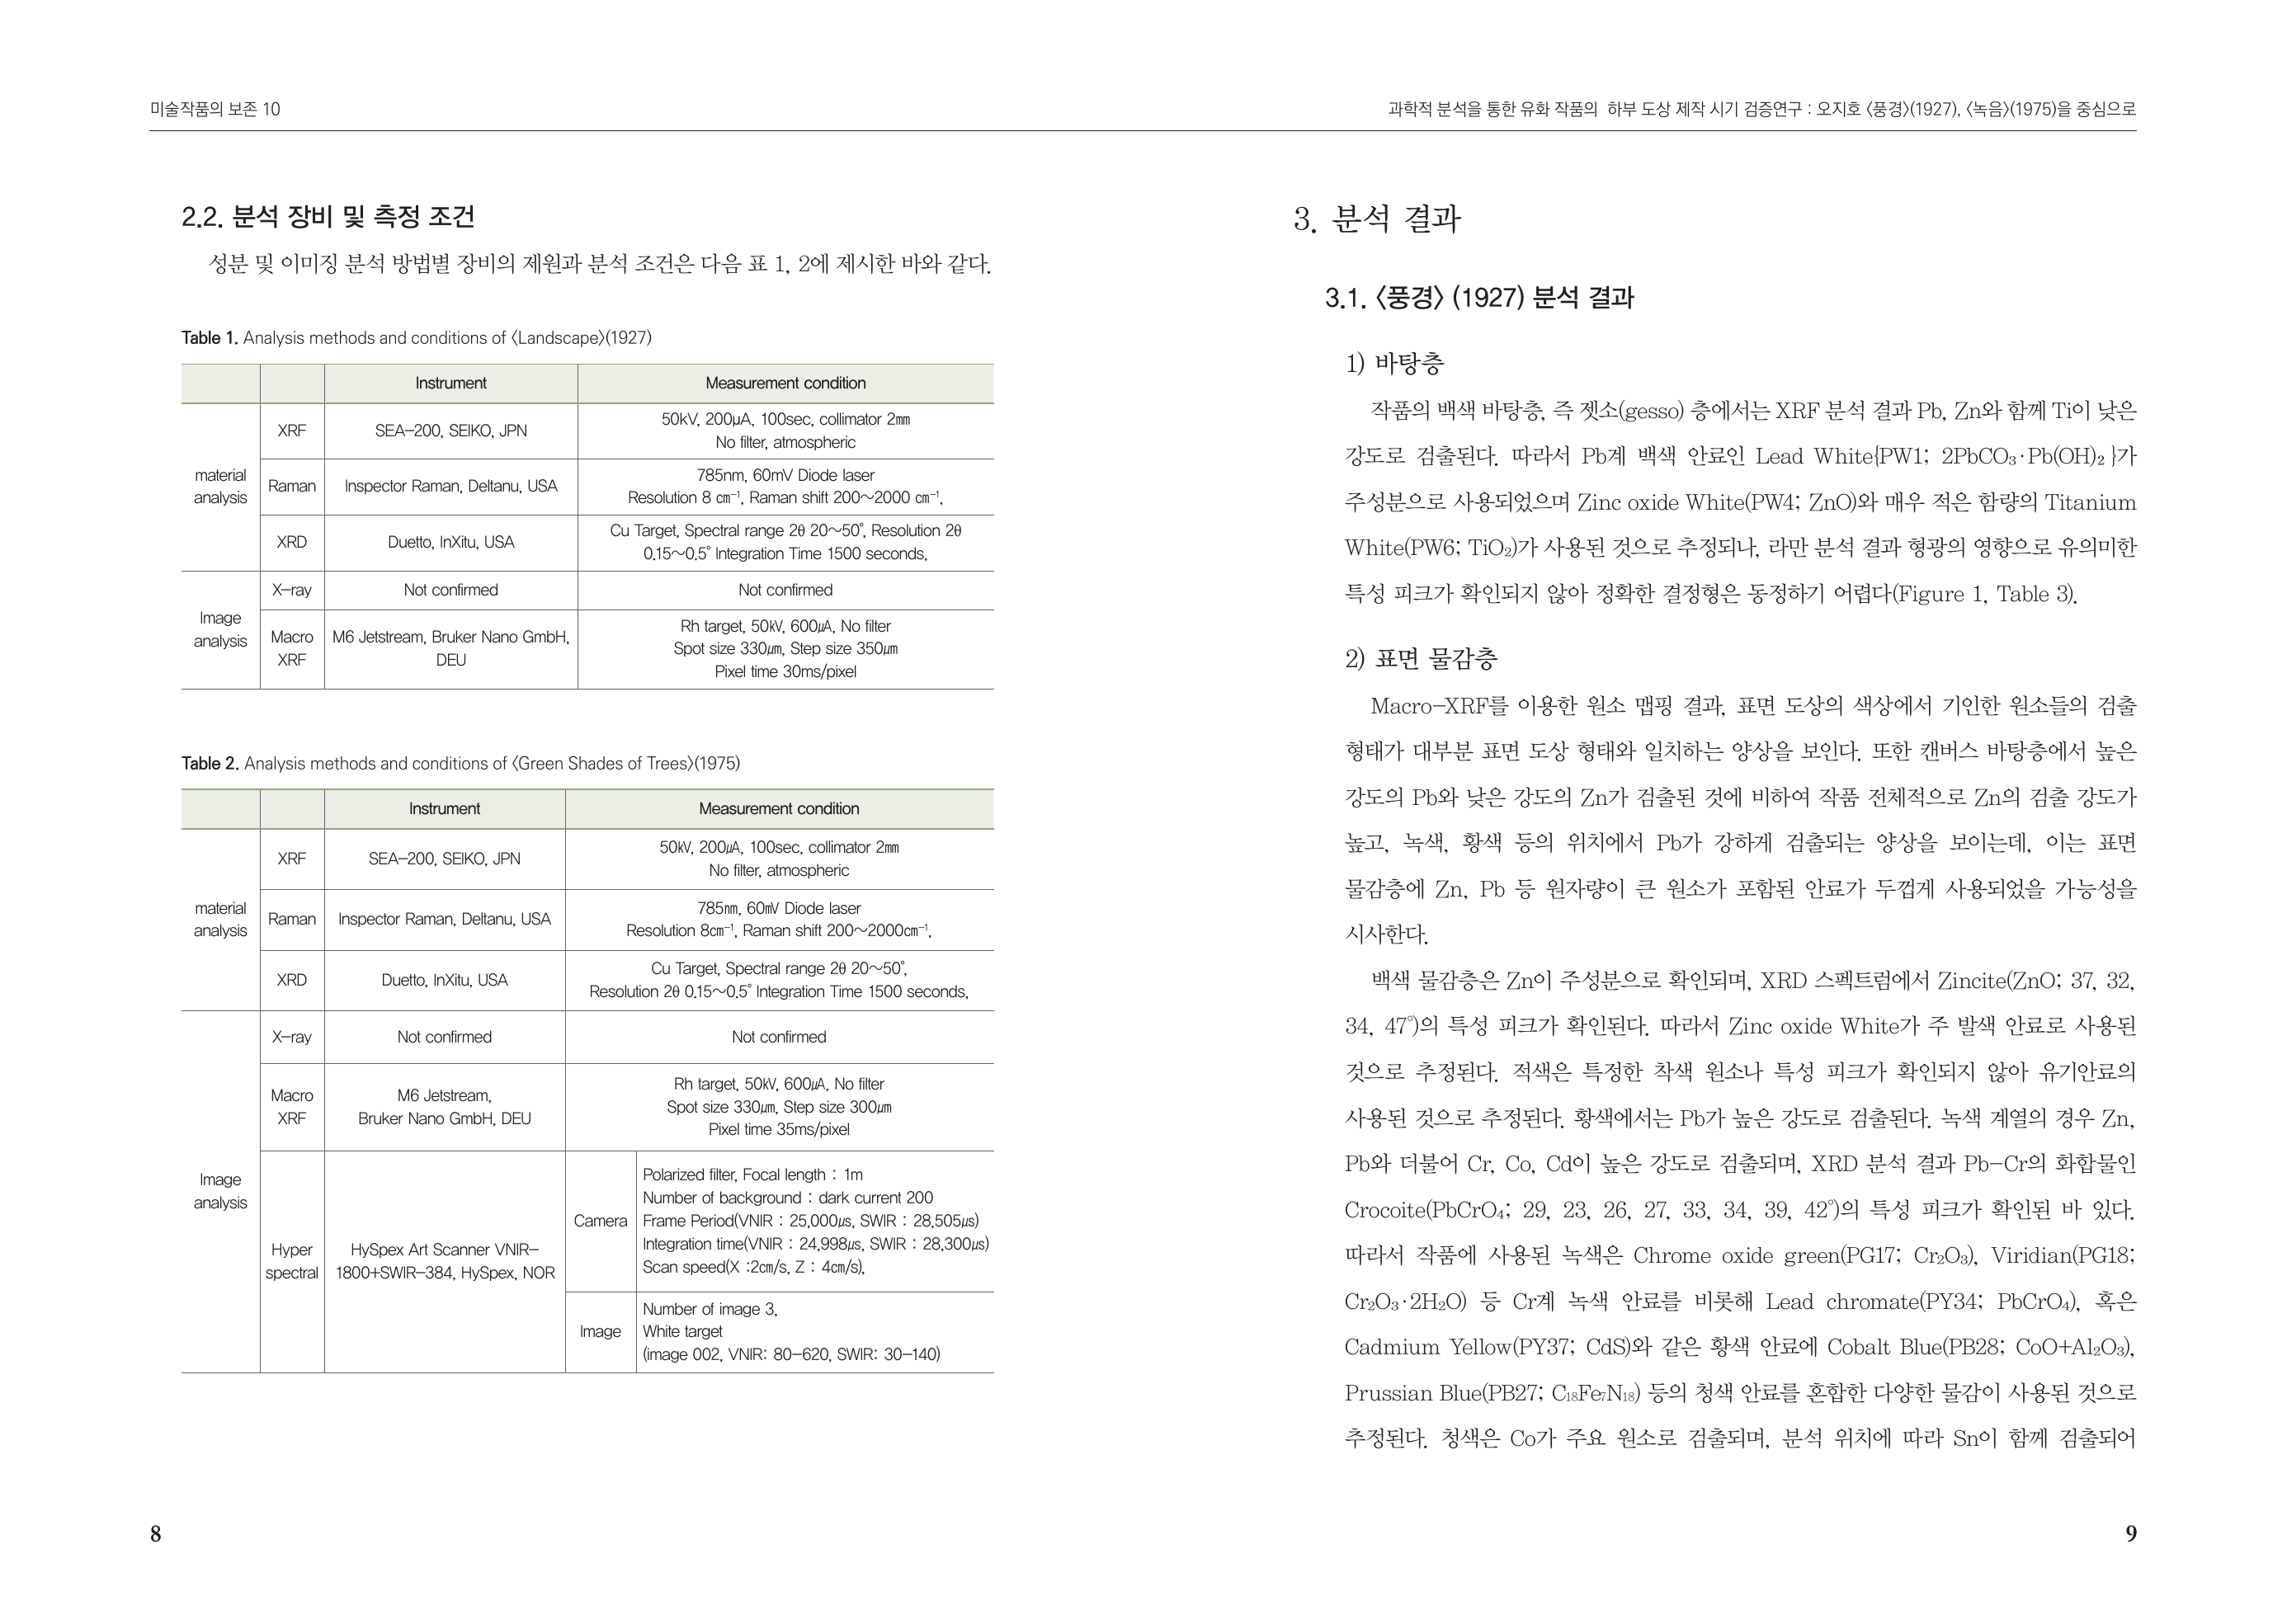

In [18]:
filename = 'image.jpg'  # I assume you have a JPG file
with open(filename, 'wb') as f:
  f.write(image_bytes)

display(Image(filename))

In [ ]:
import base64
from langchain import HuggingFacePipeline

def split_text(text, max_tokens, tokenizer):
    """토큰 수 기준으로 텍스트를 분할하는 함수"""
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk_tokens = tokens[i:i+max_tokens]
        chunk_text = tokenizer.decode(chunk_tokens)
        chunks.append(chunk_text)
    return chunks

def mm_chat_deepseek_llm(image_path, prompt, llm, tokenizer, max_allowed_tokens=16000):
    """
    image_path: 분석할 이미지 파일 경로
    prompt: 사용자 질문
    llm: 미리 생성해둔 HuggingFacePipeline 객체
    tokenizer: 모델에 맞는 토크나이저
    max_allowed_tokens: 분할할 최대 토큰 수 (안정적으로 처리할 수 있는 길이로 설정)
    """
    # 이미지 파일 읽기 및 Base64 인코딩
    with open(image_path, "rb") as f:
        image_bytes = f.read()
    img_b64 = base64.b64encode(image_bytes).decode('utf-8')
    
    # Markdown 형식의 이미지 문자열 생성
    image_markdown = f"![image](data:image/jpeg;base64,{img_b64})"
    
    # 시스템, 사용자, 이미지 정보를 포함한 전체 프롬프트 구성
    full_prompt = f"""
<|system|>
You are a helpful assistant that can answer questions about images.
Use the following image and context to answer the question.
If you don't know the answer, respond with "문서에 해당 정보가 없습니다."

<|user|>
{prompt}

<|image|>
{image_markdown}

<|assistant|>
"""
    # 프롬프트를 토크나이저를 사용해 토큰 수 기준으로 분할
    prompt_chunks = split_text(full_prompt, max_allowed_tokens, tokenizer)
    
    outputs = []
    for idx, chunk in enumerate(prompt_chunks):
        # 각 청크에 대해 모델 호출
        result = llm.invoke(chunk)
        outputs.append(result)
    
    # 각 청크의 결과를 하나의 문자열로 결합하여 반환
    final_output = "\n".join(outputs)
    return final_output

# 이미 생성해둔 HuggingFacePipeline 객체 llm과 tokenizer가 있다고 가정
# 예시 사용
response = mm_chat_deepseek_llm("image.jpg", 
                                "이미징 분석 방법별 장비의 제원과 분석 조건은 어떠한가요??", 
                                llm, tokenizer)
print(response)
